## **EfficientNetB7**




Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 tf.cast_3 (TFOpLambda)      (None, None, None, 3)     0         
                                                                 
 tf.__operators__.getitem_3   (None, None, None, 3)    0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, None, None, 3)    0         
 a)                                                              
                                                                 
 random_flip_3 (RandomFlip)  (None, None, None, 3)     0         
                                                                 
 random_rotation_3 (RandomRo  (None, None, None, 3)    0   

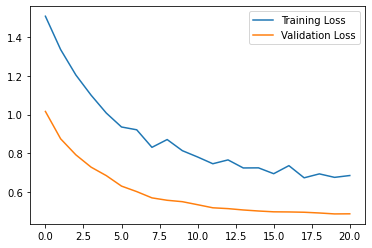

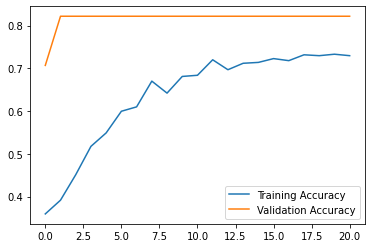

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os

from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, losses

from dotenv import load_dotenv

load_dotenv()

DATA_DIR_PATH = os.getenv('DATA_DIR_PATH')

def get_new_images_dataset(batch_size, img_width, img_height):
  data_dir = pathlib.Path(DATA_DIR_PATH)

  train_ds = keras.utils.image_dataset_from_directory(
      directory = data_dir,
      subset="training",
      batch_size=batch_size,
      image_size=(img_height, img_width),
      validation_split=0.2,
      seed=123,
      label_mode='categorical'
      )

  validation_ds = keras.utils.image_dataset_from_directory(
      directory=data_dir,
      subset="validation",
      batch_size=batch_size,
      image_size=(img_height, img_width),
      validation_split=0.2,
      seed=123,
      label_mode='categorical')
  
  return train_ds, validation_ds
  
  
def preprocess(train_ds, validation_ds):
  # captación previa almacenada en búfer para que pueda obtener datos del disco sin que la E/S se convierta en un bloqueo
  AUTOTUNE = tf.data.AUTOTUNE

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)


  # Estandarizar los datos
  # Estandarizar los valores RGB para que estén en el rango [0, 1]
  normalization_layer = layers.Rescaling(1./255)
  normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
  image_batch, labels_batch = next(iter(normalized_ds))

  return train_ds, validation_ds


def visualizar_resultados(history):
  # VISUALIZAR LOS RESULTADOS DEL ENTRENAMIENTO
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  loss = history.history['loss']
  val_loss = history.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training Loss', 'Validation Loss'])
  plt.show()

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training Accuracy', 'Validation Accuracy'])
  plt.show()


# MODELO
i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
x = tf.cast(i, tf.float32)
x = tf.keras.applications.resnet.preprocess_input(x)
# Aumento de datos
x = layers.RandomFlip("horizontal_and_vertical")(x)
x = layers.RandomRotation(0.2,  fill_mode="reflect",
    interpolation="bilinear",
    seed=None,
    fill_value=0.0)(x)
x= keras.layers.RandomZoom(
    0.3,
    width_factor=None,
    fill_mode='reflect',
    interpolation='bilinear',
    seed=None,
    fill_value=0.0)(x)

# create the base pre-trained model:
#   include_top=False allows feature extraction by removing the last dense layer
base_model = EfficientNetB7(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling='avg',
    classes=1000,
    classifier_activation="softmax"
)

# add a global spatial average pooling layer
x = base_model(x)

# Abandonar
x = layers.Dropout(0.5)(x)

# BatchNormalize
x = layers.BatchNormalization()(x)

# and a logistic layer 
predictions = layers.Dense(3, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=[i], outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
opt = Adam(lr=1e-4, decay=1e-4 / 2)
model.compile(optimizer=opt,
              loss=losses.CategoricalCrossentropy(
                  from_logits=False,
                  label_smoothing=0.0,
                  axis=-1,
                  name='categorical_crossentropy'),
              metrics=['accuracy'])

model.summary()


batch_size = 32
img_width = 224
img_height = 224

train_ds, validation_ds = get_new_images_dataset(32,224,224)
train_ds, validation_ds = preprocess(train_ds, validation_ds)

epochs = 30

# train the model on the new data for a few epochs+
history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)], verbose = 1)

# Guardar el Modelo
model.save('./EfficientNetB7-trained.h5')

np.save('my_history.npy',history.history)

visualizar_resultados(history)
